In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap
import cftime as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from numpy import inf
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
from scipy import stats
import matplotlib.pyplot as plt
import tropycal
from tropycal import tracks


In [3]:

inputs = np.load('/user/work/al18709/tc_data_flipped/KE_tracks/valid_X.npy')
training_inputs = np.load('/user/work/al18709/tc_data_flipped/KE_tracks/train_X.npy')


In [4]:
# for model in ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo'][0]:
for model in ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']:
	for scenario in ['hist','ssp245','ssp585']:
		# globals()[f'{model}_topography_{scenario}'] = np.load(f'/user/home/al18709/work/ke_track_inputs/{model}_{scenario}_topography.npy')
		print(model,scenario)
		globals()[f'{model}_tracks_{scenario}'] = pd.read_csv(f'/user/home/al18709/work/ke_track_inputs/{model}_{scenario}_tracks.csv')
		



canesm hist
canesm ssp245
canesm ssp585
cnrm6 hist
cnrm6 ssp245
cnrm6 ssp585
ecearth6 hist
ecearth6 ssp245
ecearth6 ssp585
ipsl6 hist
ipsl6 ssp245
ipsl6 ssp585
miroc6 hist
miroc6 ssp245
miroc6 ssp585
mpi6 hist
mpi6 ssp245
mpi6 ssp585
mri6 hist
mri6 ssp245
mri6 ssp585
ukmo hist
ukmo ssp245
ukmo ssp585


In [8]:
# track stats
df = pd.DataFrame({'rows':['all_storms','tropical_storms','cat1','cat2','cat3','cat4','cat5','cat6']})
for model in ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']:
	for scenario in ['hist','ssp245','ssp585']:
		data = globals()[f'{model}_tracks_{scenario}']
		if scenario == 'hist':
			yr1 = 2000
			yr2 = 2014
		else:
			yr1 = 2085
			yr2 = 2099
		cat6 = len(list(data[(data.year >= yr1) & (data.year <= yr2) & (data.v >= 169)].sid.drop_duplicates()))
		cat5 = len(list(data[(data.year >= yr1) & (data.year <= yr2) & (data.v >= 137)].sid.drop_duplicates())) - cat6
		cat4 = len(list(data[(data.year >= yr1) & (data.year <= yr2) & (data.v >= 113)].sid.drop_duplicates())) - cat5 - cat6
		cat3 = len(list(data[(data.year >= yr1) & (data.year <= yr2) & (data.v >= 96)].sid.drop_duplicates())) - cat4 - cat5 - cat6
		cat2 = len(list(data[(data.year >= yr1) & (data.year <= yr2) & (data.v >= 83)].sid.drop_duplicates())) - cat3 - cat4 - cat5 - cat6
		cat1 = len(list(data[(data.year >= yr1) & (data.year <= yr2) & (data.v >= 64)].sid.drop_duplicates())) - cat2 - cat3 - cat4 - cat5 - cat6
		tropical_storms = len(list(data[(data.year >= yr1) & (data.year <= yr2) & (data.v >= 34)].sid.drop_duplicates())) - cat1 - cat2 - cat3 - cat4 - cat5 - cat6
		all_storms = len(list(data[(data.year >= yr1) & (data.year <= yr2) & (data.v >= 34)].sid.drop_duplicates()))
		df[f'{model}_{scenario}'] = [all_storms,tropical_storms,cat1,cat2,cat3,cat4,cat5,cat6]

df	
# print(df[['miroc6_hist','miroc6_ssp245','miroc6_ssp585','ipsl6_hist','ipsl6_ssp245','ipsl6_ssp585']])
		

rows  canesm_hist  canesm_ssp245  canesm_ssp585  cnrm6_hist  \
0       all_storms         1043           1051           1175        1018   
1  tropical_storms          385            458            495         245   
2             cat1          242            221            202         224   
3             cat2           91            104            105         121   
4             cat3          111             79             95         153   
5             cat4          122            103            132         140   
6             cat5           80             67            121         107   
7             cat6           12             19             25          28   

   cnrm6_ssp245  cnrm6_ssp585  ecearth6_hist  ecearth6_ssp245  \
0          1333          1836           1058             1340   
1           367           394            349              449   
2           276           274            241              304   
3           145           157            132              134   
4           151           238            136              144   
5           173           304            114              159   
6           178           317             78              125   
7            43           152              8               25   

   ecearth6_ssp585  ...  miroc6_ssp585  mpi6_hist  mpi6_ssp245  mpi6_ssp585  \
0             1527  ...           1370       1033          801         1192   
1              455  ...            387        321          374          405   
2              331  ...            210        230          194          229   
3              163  ...            102        118           72          134   
4              187  ...            142        127           76          146   
5              201  ...            171        143           63          177   
6              165  ...            215         86           18           92   
7               25  ...            143          8            4            9   

   mri6_hist  mri6_ssp245  mri6_ssp585  ukmo_hist  ukmo_ssp245  ukmo_ssp585  
0        950          932         1259       1117         1182         1509  
1        292          350          392        320          471          480  
2        195          194          209        224          256          295  
3         98           90          110        149          103          149  
4        128          101          155        147          128          187  
5        117          105          179        148          136          197  
6         96           81          171         94           73          162  
7         24           11           43         35           15           39  

[8 rows x 25 columns]

In [10]:
ibtracs = tracks.TrackDataset(basin='all',source='ibtracs',ibtracs_mode='jtwc_neumann',catarina=True,ibtracs_url="/user/work/al18709/ibtracks/ibtracs.ALL.list.v04r00.csv")

--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (19.11 seconds)


In [17]:
print(len(ibtracs.filter_storms(thresh={'v_min':0.})))
ibtracs_filter = ibtracs.filter_storms(thresh={'v_min':34.},year_range=(2000,2014))
ibtracs_filtered = ibtracs.filter_storms(storm=ibtracs_filter,return_keys=False)
print(len(ibtracs_filter))

ibtracs_cat6 = len(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))
ibtracs_cat5 = len(ibtracs.filter_storms(thresh={'v_min':137.,'v_max':168.9},year_range=(2000,2014))) - ibtracs_cat6
ibtracs_cat4 = len(ibtracs.filter_storms(thresh={'v_min':113.,'v_max':136.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5
ibtracs_cat3 = len(ibtracs.filter_storms(thresh={'v_min':96.,'v_max':112.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4
ibtracs_cat2 = len(ibtracs.filter_storms(thresh={'v_min':83.,'v_max':95.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3
ibtracs_cat1 = len(ibtracs.filter_storms(thresh={'v_min':64.,'v_max':82.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2
ibtracs_tropical = len(ibtracs.filter_storms(thresh={'v_min':34.,'v_max':63.9},year_range=(2000,2014))) - ibtracs_cat6 - ibtracs_cat5 - ibtracs_cat4 - ibtracs_cat3 - ibtracs_cat2 - ibtracs_cat1

ibtracs_all_storms = len(ibtracs.filter_storms(thresh={'v_min':34.},year_range=(2000,2014)))


print(ibtracs.filter_storms(thresh={'v_min':169.},year_range=(2000,2014)))

df['ibtracs'] = [ibtracs_all_storms,ibtracs_tropical,ibtracs_cat1,ibtracs_cat2,ibtracs_cat3,ibtracs_cat4,ibtracs_cat5,ibtracs_cat6]
df['ibtracs']

8041
1257
['WP312013']


0    1257
1    1256
2     670
3     452
4     351
5     255
6      75
7       1
Name: ibtracs, dtype: int64

number of storms
--> Getting filtered storm tracks
--> Grouping by lat/lon/storm
--> Generating plot


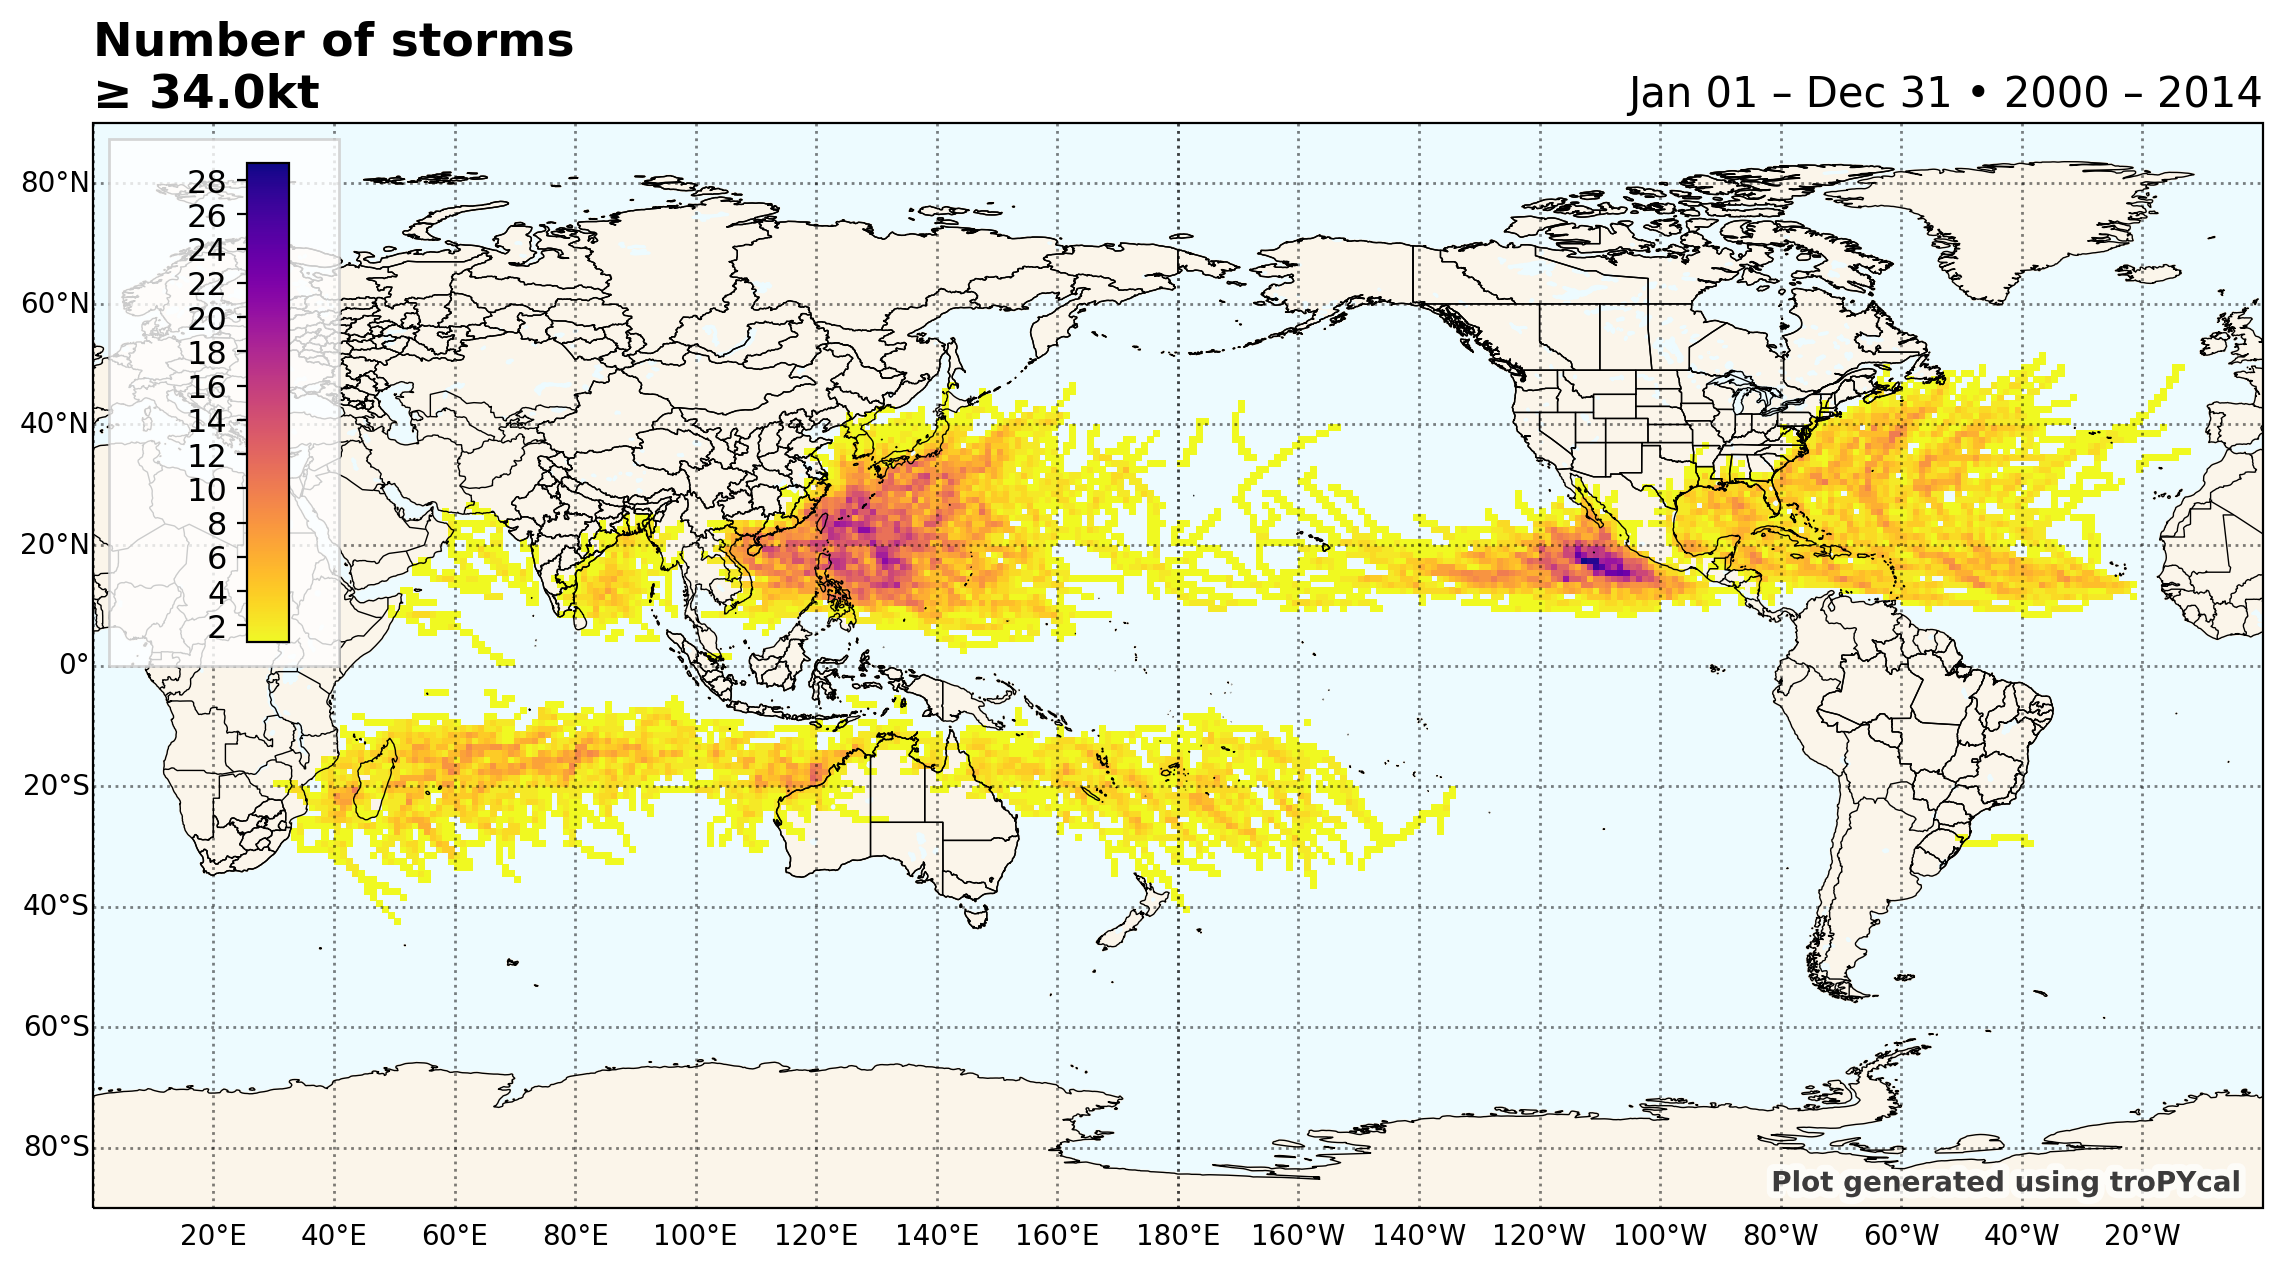

In [7]:
ibtracs.gridded_stats(request="number of storms",prop={'cmap':'plasma_r'},thresh={'v_min':34.},year_range=(2000,2014))
plt.savefig('ibtracs_density_2.png',bbox_inches='tight',dpi=300)

In [8]:
binsize = 1
def to_bin(x): return np.floor(x / binsize) * binsize
def calc_track_density(storm_data,lonshift=False,mask=True):
    binsize = 1
    latbin = storm_data.lat.map(to_bin)
    lonbin = storm_data.lon.map(to_bin)
    new_df = pd.DataFrame({'latbin': latbin, 'lonbin': lonbin, 'stormid':storm_data.sid})
    new_new_df = new_df.drop_duplicates()
    if lonshift == True:
        lat_bins = np.arange(-90, 91, 1)
        lon_bins = np.arange(-180, 181, 1)
    else:
        lat_bins = np.arange(-90, 91, 1)
        lon_bins = np.arange(0, 361, 1)
    density, _, _ = np.histogram2d(new_new_df.latbin, new_new_df.lonbin, bins=[lat_bins, lon_bins])
    masked_density = np.ma.masked_equal(density, 0)
    if mask == True:
        return masked_density
    else:
        return density
def mask(data):
    return np.ma.masked_equal(data, 0)


In [9]:
(canesm_tracks_hist.year >= 2000) & (canesm_tracks_hist.year <= 2014)

0         False
1         False
2         False
3         False
4         False
          ...  
362749     True
362750     True
362751     True
362752     True
362753     True
Name: year, Length: 362754, dtype: bool

In [10]:
print(ukmo_tracks_ssp585)

                           sid  year  month  day  hour     lat      lon  \
0       ukmo-ssp585-10803-2069  2069      2    3     6 -11.481   76.307   
1       ukmo-ssp585-10803-2069  2069      2    3     8 -11.685   76.614   
2       ukmo-ssp585-10803-2069  2069      2    3    10 -11.893   76.899   
3       ukmo-ssp585-10803-2069  2069      2    3    12 -12.102   77.161   
4       ukmo-ssp585-10803-2069  2069      2    3    14 -12.308   77.399   
...                        ...   ...    ...  ...   ...     ...      ...   
501373  ukmo-ssp585-17197-2100  2100      5   23     2 -37.486  103.198   
501374  ukmo-ssp585-17197-2100  2100      5   23     4 -38.069  104.244   
501375  ukmo-ssp585-17197-2100  2100      5   23     6 -38.643  105.307   
501376  ukmo-ssp585-17197-2100  2100      5   23     8 -39.204  106.396   
501377  ukmo-ssp585-17197-2100  2100      5   23    10 -39.744  107.504   

               v  shear     rh   u850   v850        p  
0       16.90827   8.01  74.32  13.83  -5.9

In [11]:
print(canesm_tracks_ssp585)

                             sid  year  month  day  hour     lat      lon  \
0       canesm-ssp585-10802-2069  2069     10   28     0  12.257  197.003   
1       canesm-ssp585-10802-2069  2069     10   28     2  12.474  197.015   
2       canesm-ssp585-10802-2069  2069     10   28     4  12.687  197.025   
3       canesm-ssp585-10802-2069  2069     10   28     6  12.896  197.021   
4       canesm-ssp585-10802-2069  2069     10   28     8  13.101  197.004   
...                          ...   ...    ...  ...   ...     ...      ...   
389074  canesm-ssp585-17200-2100  2100     10   10    18  41.728  143.651   
389075  canesm-ssp585-17200-2100  2100     10   10    20  42.223  143.623   
389076  canesm-ssp585-17200-2100  2100     10   10    22  42.690  143.579   
389077  canesm-ssp585-17200-2100  2100     10   11     0  43.126  143.523   
389078  canesm-ssp585-17200-2100  2100     10   11     2  43.533  143.463   

               v  shear     rh   u850  v850        p  
0       14.35450   3

In [12]:
for model in ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']:
	for scenario in ['hist','ssp245','ssp585']:
		# globals()[f'{model}_topography_{scenario}'] = np.load(f'/user/home/al18709/work/ke_track_inputs/{model}_{scenario}_topography.npy')
		print(model,scenario)
		if scenario == 'hist':
			yr1 = 2000
			yr2 = 2014
		else:
			yr1 = 2085
			yr2 = 2099
		data = globals()[f'{model}_tracks_{scenario}']
		wind_thresh = 34
		globals()[f'{model}_{scenario}_masked_density'] = calc_track_density(data[(data.year >= yr1) & (data.year <= yr2) & (data.v >= wind_thresh)])
	

canesm hist


canesm ssp245
canesm ssp585
cnrm6 hist
cnrm6 ssp245
cnrm6 ssp585
ecearth6 hist
ecearth6 ssp245
ecearth6 ssp585
ipsl6 hist
ipsl6 ssp245
ipsl6 ssp585
miroc6 hist
miroc6 ssp245
miroc6 ssp585
mpi6 hist


KeyboardInterrupt: 

In [ ]:
# # Compute histogram of cyclone tracks
# ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']
# canesm_hist_masked_density = calc_track_density(canesm_tracks_hist[(canesm_tracks_hist.year >= 2000) & (canesm_tracks_hist.year <= 2014)])
# cnrm6_hist_masked_density = calc_track_density(cnrm6_tracks_hist[(cnrm6_tracks_hist.year >= 2000) & (cnrm6_tracks_hist.year <= 2014)])
# ecearth6_hist_masked_density = calc_track_density(ecearth6_tracks_hist[(ecearth6_tracks_hist.year >= 2000) & (ecearth6_tracks_hist.year <= 2014)])
# ipsl6_hist_masked_density = calc_track_density(ipsl6_tracks_hist[(ipsl6_tracks_hist.year >= 2000) & (ipsl6_tracks_hist.year <= 2014)])
# miroc6_hist_masked_density = calc_track_density(miroc6_tracks_hist[(miroc6_tracks_hist.year >= 2000) & (miroc6_tracks_hist.year <= 2014)])
# mpi6_hist_masked_density = calc_track_density(mpi6_tracks_hist[(mpi6_tracks_hist.year >= 2000) & (mpi6_tracks_hist.year <= 2014)])
# mri6_hist_masked_density = calc_track_density(mri6_tracks_hist[(mri6_tracks_hist.year >= 2000) & (mri6_tracks_hist.year <= 2014)])
# ukmo_hist_masked_density = calc_track_density(ukmo_tracks_hist[(ukmo_tracks_hist.year >= 2000) & (ukmo_tracks_hist.year <= 2014)])



In [ ]:
# canesm_ssp585_masked_density = calc_track_density(canesm_tracks_ssp585[(canesm_tracks_ssp585.year >= 2085) & (canesm_tracks_ssp585.year <= 2099)])
# cnrm6_ssp585_masked_density = calc_track_density(cnrm6_tracks_ssp585[(cnrm6_tracks_ssp585.year >= 2085) & (cnrm6_tracks_ssp585.year <= 2099)])
# ecearth6_ssp585_masked_density = calc_track_density(ecearth6_tracks_ssp585[(ecearth6_tracks_ssp585.year >= 2085) & (ecearth6_tracks_ssp585.year <= 2099)])
# ipsl6_ssp585_masked_density = calc_track_density(ipsl6_tracks_ssp585[(ipsl6_tracks_ssp585.year >= 2085) & (ipsl6_tracks_ssp585.year <= 2099)])
# miroc6_ssp585_masked_density = calc_track_density(miroc6_tracks_ssp585[(miroc6_tracks_ssp585.year >= 2085) & (miroc6_tracks_ssp585.year <= 2099)])
# mpi6_ssp585_masked_density = calc_track_density(mpi6_tracks_ssp585[(mpi6_tracks_ssp585.year >= 2085) & (mpi6_tracks_ssp585.year <= 2099)])
# mri6_ssp585_masked_density = calc_track_density(mri6_tracks_ssp585[(mri6_tracks_ssp585.year >= 2085) & (mri6_tracks_ssp585.year <= 2099)])
# ukmo_ssp585_masked_density = calc_track_density(ukmo_tracks_ssp585[(ukmo_tracks_ssp585.year >= 2085) & (ukmo_tracks_ssp585.year <= 2099)])


In [ ]:
mswep_sids = pd.read_csv('/user/home/al18709/work/CMIP6/MSWEP/storm_rain/storm_sid_NH.csv')
indices = (mswep_sids['year'] >= 2000) & (mswep_sids['year'] <= 2014)
mswep_sids = mswep_sids[indices].reset_index()
meta_mswep = pd.DataFrame({'sid':mswep_sids.sid ,'lat':mswep_sids.centre_lat, 'lon':mswep_sids.centre_lon, 'hour':mswep_sids.hour, 'year':mswep_sids.year})


In [ ]:
mswep_sids

index  Unnamed: 0            sid  year  month  day  hour  centre_lat  \
0      27433       27437  2000003S13082  2000      1    8     0    -15.9000   
1      27434       27438  2000003S13082  2000      1    8     3    -16.1667   
2      27435       27439  2000003S13082  2000      1    8     6    -16.4333   
3      27436       27440  2000003S13082  2000      1    8     9    -16.6150   
4      27437       27441  2000003S13082  2000      1    8    12    -16.7667   
...      ...         ...            ...   ...    ...  ...   ...         ...   
18116  45549       45555  2014356S08101  2014     12   30    18    -18.6500   
18117  45550       45556  2014356S08101  2014     12   30    21    -18.9860   
18118  45551       45557  2014356S08101  2014     12   31     0    -19.3000   
18119  45552       45558  2014356S08101  2014     12   31     3    -19.6211   
18120  45553       45559  2014356S08101  2014     12   31     6    -19.9500   

       centre_lon  
0         74.7667  
1         74.0869  
2         73.3667  
3         72.6556  
4         72.0000  
...           ...  
18116     88.5000  
18117     88.1996  
18118     87.9000  
18119     87.5123  
18120     87.0500  

[18121 rows x 9 columns]

In [ ]:

ibtracs_masked_density = calc_track_density(meta_mswep,lonshift=True)

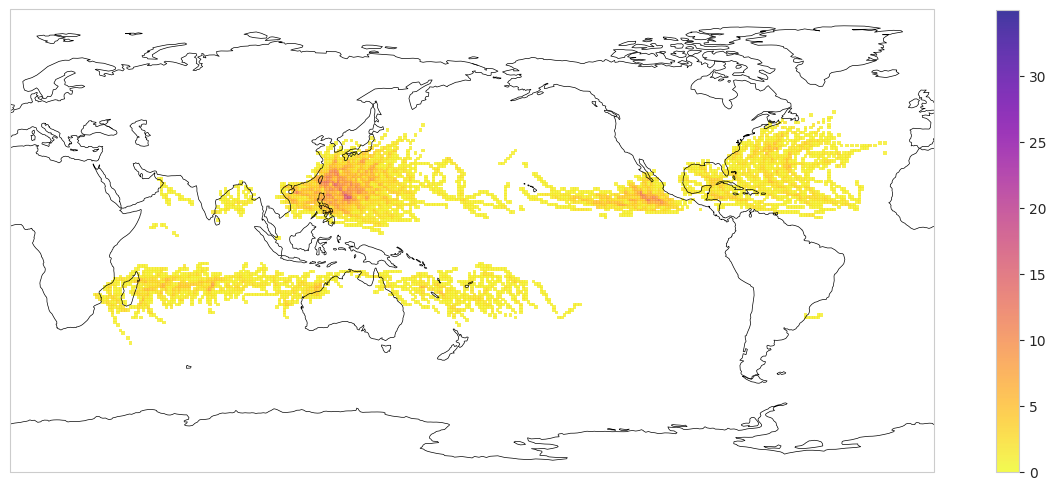

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(16, 6),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
im = ax.pcolor(np.arange(-180,180),np.arange(-90,90),ibtracs_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=35)
ax.add_feature(cfeature.COASTLINE,linewidth=0.5) 
ax.set_global()
plt.colorbar(im,ticks=range(0,35,5),ax=ax)
plt.savefig('ibtrack_density.png',bbox_inches='tight',dpi=300)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

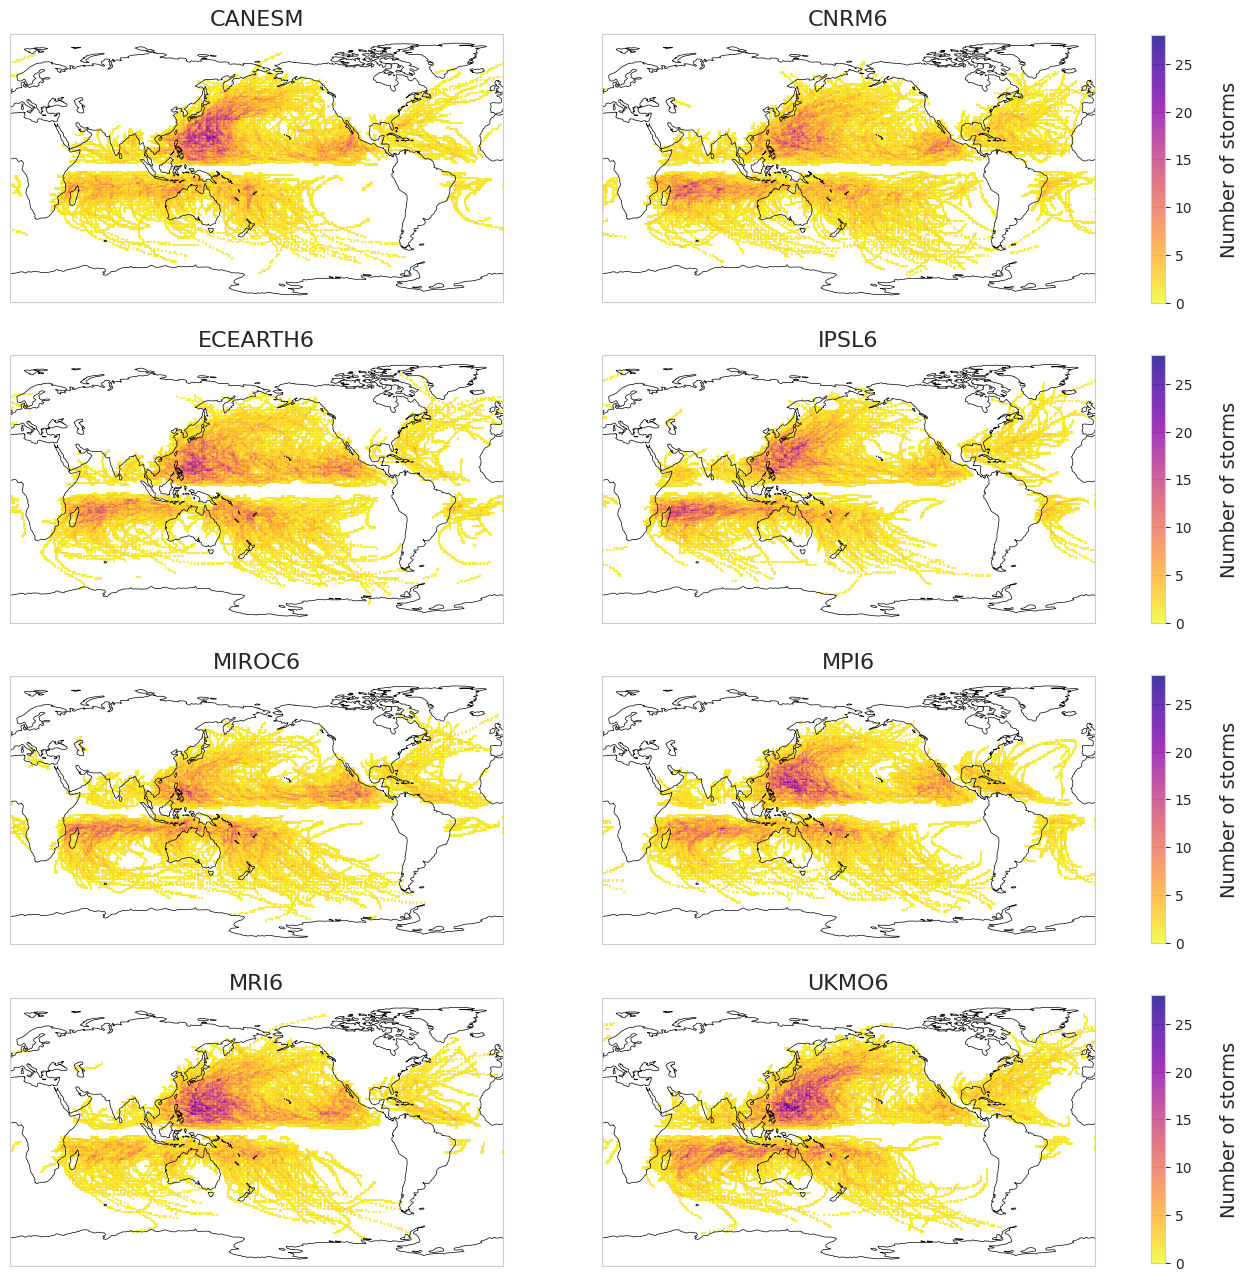

In [ ]:
sns.set_style("whitegrid")  # You can change the style to your preference
fig, axes = plt.subplots(4, 2, figsize=(14, 16),gridspec_kw={'width_ratios': [1, 1]},subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
# titles = ['Mean Sea level pressure (hPa)', 'U 850 hPa ($ms^{-1}$)', 'V 850 hPa ($ms^{-1}$)', 'Wind shear', 'Latitude (degrees North)', 'Longitude (degrees East)']
# labels = ['a.','b.','c.','d.','e.','f.']

vmax = 28
im = axes[0,0].pcolor(np.arange(0,360),np.arange(-90,90),canesm_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[0,0].set_title('CANESM',fontsize=16)

im = axes[0,1].pcolor(np.arange(0,360),np.arange(-90,90),cnrm6_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[0,1].set_title('CNRM6',fontsize=16)

im = axes[1,0].pcolor(np.arange(0,360),np.arange(-90,90),ecearth6_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[1,0].set_title('ECEARTH6',fontsize=16)

im = axes[1,1].pcolor(np.arange(0,360),np.arange(-90,90),ipsl6_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[1,1].set_title('IPSL6',fontsize=16)

im = axes[2,0].pcolor(np.arange(0,360),np.arange(-90,90),miroc6_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[2,0].set_title('MIROC6',fontsize=16)

im = axes[2,1].pcolor(np.arange(0,360),np.arange(-90,90),mpi6_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[2,1].set_title('MPI6',fontsize=16)

im = axes[3,0].pcolor(np.arange(0,360),np.arange(-90,90),mri6_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[3,0].set_title('MRI6',fontsize=16)

im = axes[3,1].pcolor(np.arange(0,360),np.arange(-90,90),ukmo_hist_masked_density, transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[3,1].set_title('UKMO6',fontsize=16)

for ax in [axes[0,0],axes[0,1],axes[1,0],axes[1,1],axes[2,0],axes[2,1],axes[3,0],axes[3,1]]:
    ax.add_feature(cfeature.COASTLINE,linewidth=0.5)   
    ax.set_aspect('auto', adjustable=None)
    ax.set_global()


# divider = make_axes_locatable(axes[0,1])
# cax1 = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(im, cax=cax1)
# add colourbar
cbar_ax = fig.add_axes([0.94, 0.712, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(0,35,5)).set_label(label='Number of storms',size=14, labelpad=20)
cbar_ax = fig.add_axes([0.94, 0.512, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(0,35,5)).set_label(label='Number of storms',size=14, labelpad=20)
cbar_ax = fig.add_axes([0.94, 0.312, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(0,35,5)).set_label(label='Number of storms',size=14, labelpad=20)
cbar_ax = fig.add_axes([0.94, 0.112, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(0,35,5)).set_label(label='Number of storms',size=14, labelpad=20)

plt.savefig('track_density2.png',bbox_inches='tight',dpi=300)


In [ ]:
for model in ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']:
	for scenario in ['hist','ssp245','ssp585']:
		# globals()[f'{model}_topography_{scenario}'] = np.load(f'/user/home/al18709/work/ke_track_inputs/{model}_{scenario}_topography.npy')
		print(model,scenario)
		if scenario == 'hist':
			yr1 = 2000
			yr2 = 2014
		else:
			yr1 = 2085
			yr2 = 2099
		data = globals()[f'{model}_tracks_{scenario}']
		wind_thresh = 34
		globals()[f'{model}_{scenario}_masked_density'] = calc_track_density(data[(data.year >= yr1) & (data.year <= yr2) & (data.v >= wind_thresh)],mask=False)


canesm hist
canesm ssp245
canesm ssp585
cnrm6 hist
cnrm6 ssp245
cnrm6 ssp585
ecearth6 hist


ecearth6 ssp245
ecearth6 ssp585
ipsl6 hist
ipsl6 ssp245
ipsl6 ssp585
miroc6 hist
miroc6 ssp245
miroc6 ssp585
mpi6 hist
mpi6 ssp245
mpi6 ssp585
mri6 hist
mri6 ssp245
mri6 ssp585
ukmo hist
ukmo ssp245
ukmo ssp585


In [ ]:
# # Compute histogram of cyclone tracks
# ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']
# canesm_hist_masked_density = calc_track_density(canesm_tracks_hist[(canesm_tracks_hist.year >= 2000) & (canesm_tracks_hist.year <= 2014)],mask=False)
# cnrm6_hist_masked_density = calc_track_density(cnrm6_tracks_hist[(cnrm6_tracks_hist.year >= 2000) & (cnrm6_tracks_hist.year <= 2014)],mask=False)
# ecearth6_hist_masked_density = calc_track_density(ecearth6_tracks_hist[(ecearth6_tracks_hist.year >= 2000) & (ecearth6_tracks_hist.year <= 2014)],mask=False)
# ipsl6_hist_masked_density = calc_track_density(ipsl6_tracks_hist[(ipsl6_tracks_hist.year >= 2000) & (ipsl6_tracks_hist.year <= 2014)],mask=False)
# miroc6_hist_masked_density = calc_track_density(miroc6_tracks_hist[(miroc6_tracks_hist.year >= 2000) & (miroc6_tracks_hist.year <= 2014)],mask=False)
# mpi6_hist_masked_density = calc_track_density(mpi6_tracks_hist[(mpi6_tracks_hist.year >= 2000) & (mpi6_tracks_hist.year <= 2014)],mask=False)
# mri6_hist_masked_density = calc_track_density(mri6_tracks_hist[(mri6_tracks_hist.year >= 2000) & (mri6_tracks_hist.year <= 2014)],mask=False)
# ukmo_hist_masked_density = calc_track_density(ukmo_tracks_hist[(ukmo_tracks_hist.year >= 2000) & (ukmo_tracks_hist.year <= 2014)],mask=False)

# canesm_ssp585_masked_density = calc_track_density(canesm_tracks_ssp585[(canesm_tracks_ssp585.year >= 2085) & (canesm_tracks_ssp585.year <= 2099)],mask=False)
# cnrm6_ssp585_masked_density = calc_track_density(cnrm6_tracks_ssp585[(cnrm6_tracks_ssp585.year >= 2085) & (cnrm6_tracks_ssp585.year <= 2099)],mask=False)
# ecearth6_ssp585_masked_density = calc_track_density(ecearth6_tracks_ssp585[(ecearth6_tracks_ssp585.year >= 2085) & (ecearth6_tracks_ssp585.year <= 2099)],mask=False)
# ipsl6_ssp585_masked_density = calc_track_density(ipsl6_tracks_ssp585[(ipsl6_tracks_ssp585.year >= 2085) & (ipsl6_tracks_ssp585.year <= 2099)],mask=False)
# miroc6_ssp585_masked_density = calc_track_density(miroc6_tracks_ssp585[(miroc6_tracks_ssp585.year >= 2085) & (miroc6_tracks_ssp585.year <= 2099)],mask=False)
# mpi6_ssp585_masked_density = calc_track_density(mpi6_tracks_ssp585[(mpi6_tracks_ssp585.year >= 2085) & (mpi6_tracks_ssp585.year <= 2099)],mask=False)
# mri6_ssp585_masked_density = calc_track_density(mri6_tracks_ssp585[(mri6_tracks_ssp585.year >= 2085) & (mri6_tracks_ssp585.year <= 2099)],mask=False)
# ukmo_ssp585_masked_density = calc_track_density(ukmo_tracks_ssp585[(ukmo_tracks_ssp585.year >= 2085) & (ukmo_tracks_ssp585.year <= 2099)],mask=False)


In [ ]:
print(mpi6_tracks_ssp585)

                           sid  year  month  day  hour     lat      lon  \
0       mpi6-ssp585-10812-2069  2069      5    1    12   8.305  246.890   
1       mpi6-ssp585-10812-2069  2069      5    1    14   8.455  247.061   
2       mpi6-ssp585-10812-2069  2069      5    1    16   8.610  247.216   
3       mpi6-ssp585-10812-2069  2069      5    1    18   8.770  247.351   
4       mpi6-ssp585-10812-2069  2069      5    1    20   8.936  247.463   
...                        ...   ...    ...  ...   ...     ...      ...   
400666  mpi6-ssp585-17199-2100  2100      4   22    16 -17.778   82.993   
400667  mpi6-ssp585-17199-2100  2100      4   22    18 -17.656   82.465   
400668  mpi6-ssp585-17199-2100  2100      4   22    20 -17.530   81.933   
400669  mpi6-ssp585-17199-2100  2100      4   22    22 -17.408   81.404   
400670  mpi6-ssp585-17199-2100  2100      4   23     0 -17.292   80.881   

               v  shear     rh   u850  v850        p  
0       14.28040   3.79  57.84   8.47  1.73 

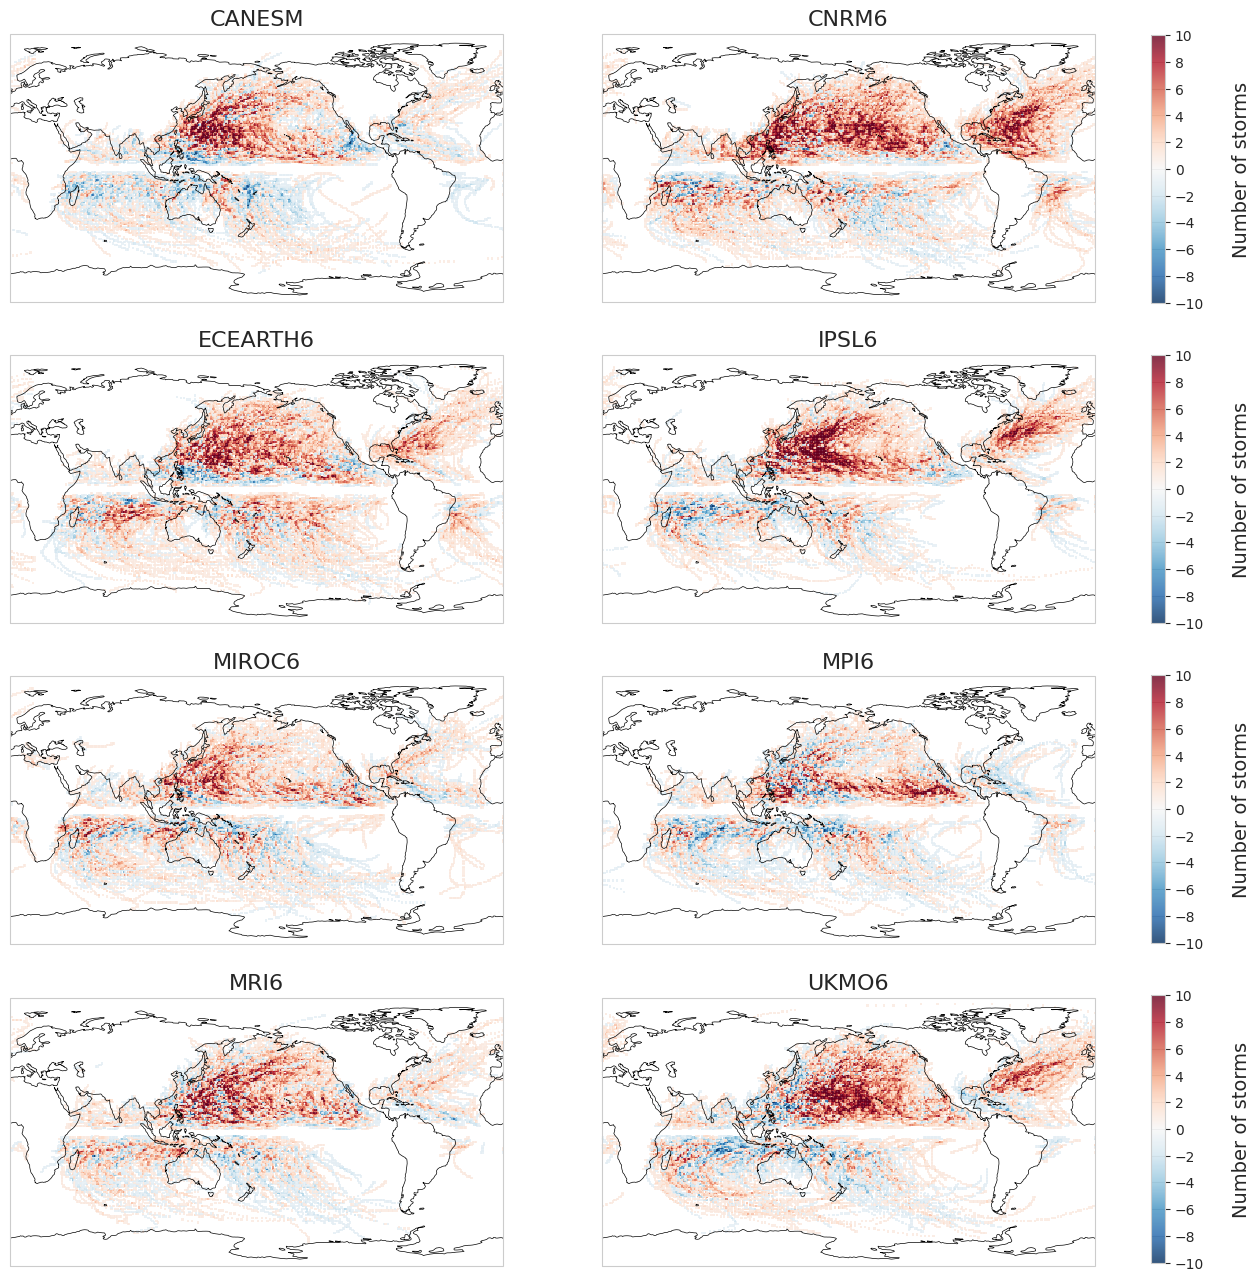

In [ ]:
sns.set_style("whitegrid")  # You can change the style to your preference
fig, axes = plt.subplots(4, 2, figsize=(14, 16),gridspec_kw={'width_ratios': [1, 1]},subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
# titles = ['Mean Sea level pressure (hPa)', 'U 850 hPa ($ms^{-1}$)', 'V 850 hPa ($ms^{-1}$)', 'Wind shear', 'Latitude (degrees North)', 'Longitude (degrees East)']
# labels = ['a.','b.','c.','d.','e.','f.']

vmin=-10
vmax = 10 
cmap = 'RdBu_r'
im = axes[0,0].pcolor(np.arange(0,360),np.arange(-90,90),mask(canesm_ssp585_masked_density - canesm_hist_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap=cmap,vmin=vmin,
                        vmax=vmax)
axes[0,0].set_title('CANESM',fontsize=16)

im = axes[0,1].pcolor(np.arange(0,360),np.arange(-90,90),mask(cnrm6_ssp585_masked_density - cnrm6_hist_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap=cmap,vmin=vmin,
                        vmax=vmax)
axes[0,1].set_title('CNRM6',fontsize=16)

im = axes[1,0].pcolor(np.arange(0,360),np.arange(-90,90),mask(ecearth6_ssp585_masked_density - ecearth6_hist_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap=cmap,vmin=vmin,
                        vmax=vmax)
axes[1,0].set_title('ECEARTH6',fontsize=16)

im = axes[1,1].pcolor(np.arange(0,360),np.arange(-90,90),mask(ipsl6_ssp585_masked_density - ipsl6_hist_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap=cmap,vmin=vmin,
                        vmax=vmax)
axes[1,1].set_title('IPSL6',fontsize=16)

im = axes[2,0].pcolor(np.arange(0,360),np.arange(-90,90),mask(miroc6_ssp585_masked_density - miroc6_hist_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap=cmap,vmin=vmin,
                        vmax=vmax)
axes[2,0].set_title('MIROC6',fontsize=16)

im = axes[2,1].pcolor(np.arange(0,360),np.arange(-90,90),mask(mpi6_ssp585_masked_density - mpi6_hist_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap=cmap,vmin=vmin,
                        vmax=vmax)
axes[2,1].set_title('MPI6',fontsize=16)

im = axes[3,0].pcolor(np.arange(0,360),np.arange(-90,90),mask(mri6_ssp585_masked_density - mri6_hist_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap=cmap,vmin=vmin,
                        vmax=vmax)
axes[3,0].set_title('MRI6',fontsize=16)

im = axes[3,1].pcolor(np.arange(0,360),np.arange(-90,90),mask(ukmo_ssp585_masked_density - ukmo_hist_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap=cmap,vmin=vmin,
                        vmax=vmax)
axes[3,1].set_title('UKMO6',fontsize=16)

for ax in [axes[0,0],axes[0,1],axes[1,0],axes[1,1],axes[2,0],axes[2,1],axes[3,0],axes[3,1]]:
    ax.add_feature(cfeature.COASTLINE,linewidth=0.5)   
    ax.set_aspect('auto', adjustable=None)
    ax.set_global()


# divider = make_axes_locatable(axes[0,1])
# cax1 = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(im, cax=cax1)
# add colourbar
cbar_ax = fig.add_axes([0.94, 0.712, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(-10,12,2)).set_label(label='Number of storms',size=14, labelpad=20)
cbar_ax = fig.add_axes([0.94, 0.512, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(-10,12,2)).set_label(label='Number of storms',size=14, labelpad=20)
cbar_ax = fig.add_axes([0.94, 0.312, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(-10,12,2)).set_label(label='Number of storms',size=14, labelpad=20)
cbar_ax = fig.add_axes([0.94, 0.112, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(-10,12,2)).set_label(label='Number of storms',size=14, labelpad=20)

plt.savefig('track_density_anomaly2.png',bbox_inches='tight',dpi=300)


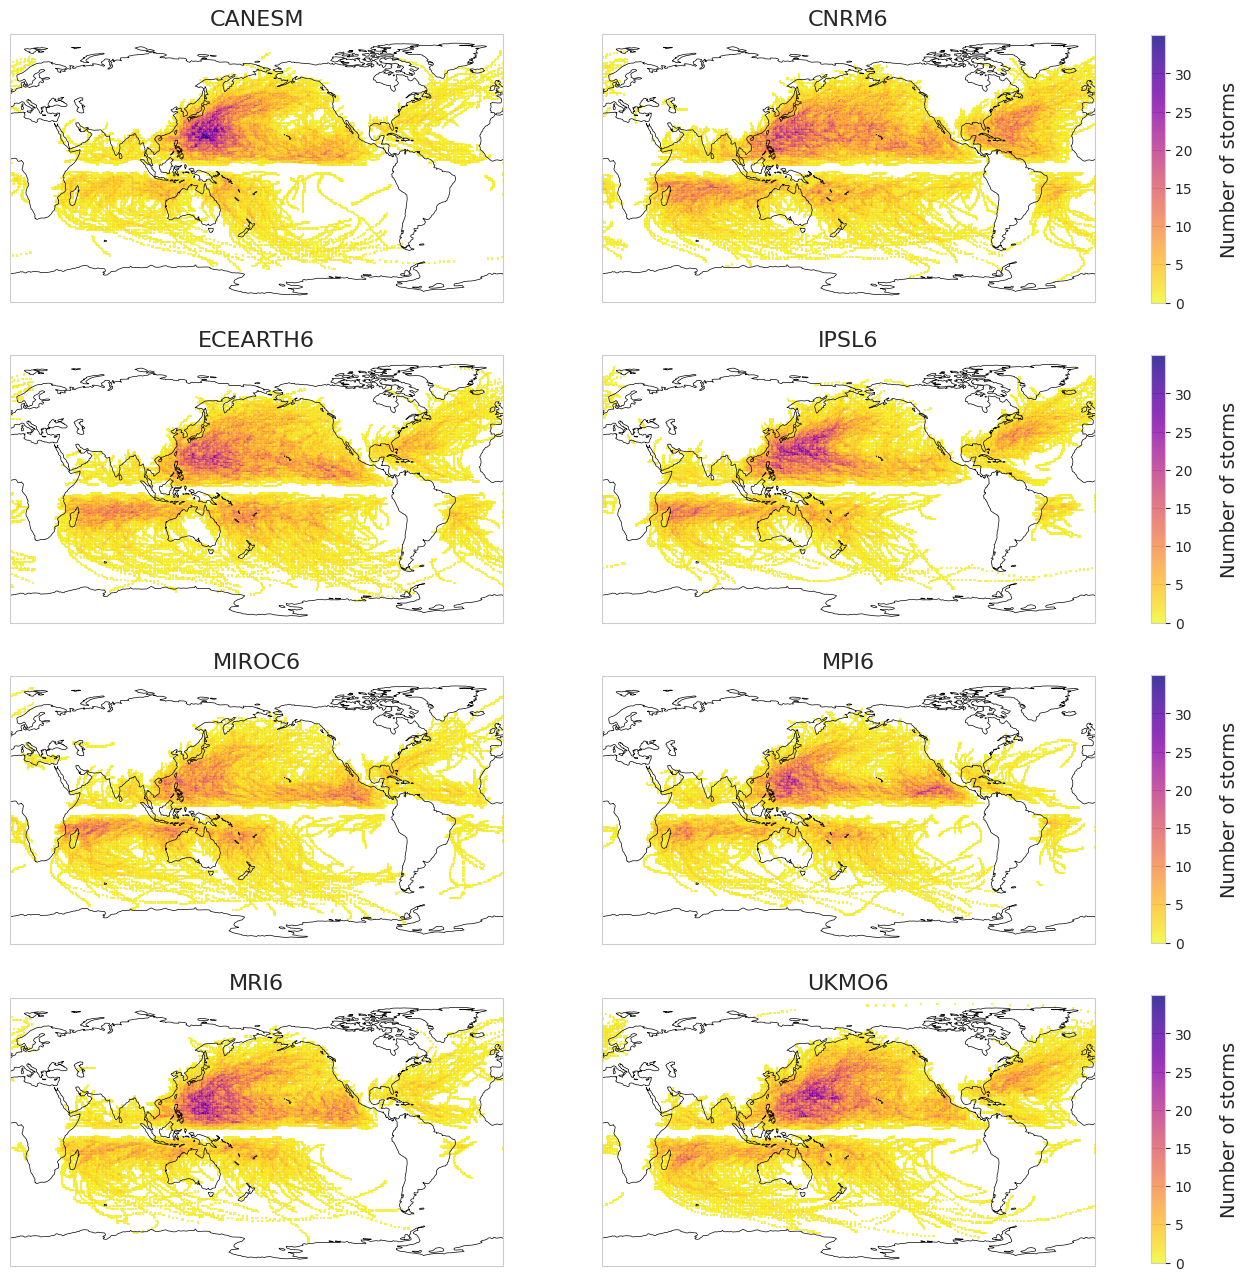

In [ ]:
sns.set_style("whitegrid")  # You can change the style to your preference
fig, axes = plt.subplots(4, 2, figsize=(14, 16),gridspec_kw={'width_ratios': [1, 1]},subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
# titles = ['Mean Sea level pressure (hPa)', 'U 850 hPa ($ms^{-1}$)', 'V 850 hPa ($ms^{-1}$)', 'Wind shear', 'Latitude (degrees North)', 'Longitude (degrees East)']
# labels = ['a.','b.','c.','d.','e.','f.']

vmax = 35 
im = axes[0,0].pcolor(np.arange(0,360),np.arange(-90,90),mask(canesm_ssp585_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[0,0].set_title('CANESM',fontsize=16)

im = axes[0,1].pcolor(np.arange(0,360),np.arange(-90,90),mask(cnrm6_ssp585_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[0,1].set_title('CNRM6',fontsize=16)

im = axes[1,0].pcolor(np.arange(0,360),np.arange(-90,90),mask(ecearth6_ssp585_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[1,0].set_title('ECEARTH6',fontsize=16)

im = axes[1,1].pcolor(np.arange(0,360),np.arange(-90,90),mask(ipsl6_ssp585_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[1,1].set_title('IPSL6',fontsize=16)

im = axes[2,0].pcolor(np.arange(0,360),np.arange(-90,90),mask(miroc6_ssp585_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[2,0].set_title('MIROC6',fontsize=16)

im = axes[2,1].pcolor(np.arange(0,360),np.arange(-90,90),mask(mpi6_ssp585_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[2,1].set_title('MPI6',fontsize=16)

im = axes[3,0].pcolor(np.arange(0,360),np.arange(-90,90),mask(mri6_ssp585_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[3,0].set_title('MRI6',fontsize=16)

im = axes[3,1].pcolor(np.arange(0,360),np.arange(-90,90),mask(ukmo_ssp585_masked_density), transform=ccrs.PlateCarree(),alpha=0.8,cmap='plasma_r',vmin=0,
                        vmax=vmax)
axes[3,1].set_title('UKMO6',fontsize=16)

for ax in [axes[0,0],axes[0,1],axes[1,0],axes[1,1],axes[2,0],axes[2,1],axes[3,0],axes[3,1]]:
    ax.add_feature(cfeature.COASTLINE,linewidth=0.5)   
    ax.set_aspect('auto', adjustable=None)
    ax.set_global()


# divider = make_axes_locatable(axes[0,1])
# cax1 = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(im, cax=cax1)
# add colourbar
cbar_ax = fig.add_axes([0.94, 0.712, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(0,35,5)).set_label(label='Number of storms',size=14, labelpad=20)
cbar_ax = fig.add_axes([0.94, 0.512, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(0,35,5)).set_label(label='Number of storms',size=14, labelpad=20)
cbar_ax = fig.add_axes([0.94, 0.312, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(0,35,5)).set_label(label='Number of storms',size=14, labelpad=20)
cbar_ax = fig.add_axes([0.94, 0.112, 0.01, 0.167])
cb = fig.colorbar(im, cax=cbar_ax,shrink=0.005,ticks=range(0,35,5)).set_label(label='Number of storms',size=14, labelpad=20)

plt.savefig('track_density_ssp585_2.png',bbox_inches='tight',dpi=300)


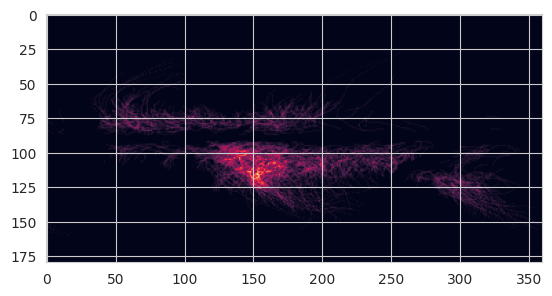

In [ ]:
plt.imshow(ukmo_ssp585_masked_density)

In [ ]:
# for i,l in enumerate(canesm_tracks_hist.lon):
#     if l > 180:
#         canesm_tracks_hist.lon[i] = l - 360

# sids = canesm_tracks_hist.sid
# sids_unique=sids.drop_duplicates()
# tracks_grouped = canesm_tracks_hist.groupby('sid')


# for sid in sids_unique:
#     storm = tracks_grouped.get_group(sid)

In [ ]:
for i in range(6):
    # row, col = divmod(i, 3)
    print(titles[i])
    data_ssp585 = np.concatenate((canesm_tracks_ssp585[:,i],cnrm6_tracks_ssp585[:,i],ecearth6_tracks_ssp585[:,i],miroc6_tracks_ssp585[:,i],mpi6_tracks_ssp585[:,i]))
    data_ssp245 = np.concatenate((canesm_tracks_ssp245[:,i],cnrm6_tracks_ssp245[:,i],ecearth6_tracks_ssp245[:,i],miroc6_tracks_ssp245[:,i],mpi6_tracks_ssp245[:,i]))
    data_hist = np.concatenate((canesm_tracks_hist[:,i],cnrm6_tracks_hist[:,i],ecearth6_tracks_hist[:,i],miroc6_tracks_hist[:,i],mpi6_tracks_hist[:,i]))
    

    # 1. Kolmogorov-Smirnov Test
    ks_statistic, ks_p_value = stats.ks_2samp(data_hist, data_ssp245)
    print(f"Kolmogorov-Smirnov Test: Statistic = {ks_statistic}, p-value = {ks_p_value}")
    ks_statistic, ks_p_value = stats.ks_2samp(data_hist, data_ssp585)
    print(f"Kolmogorov-Smirnov Test: Statistic = {ks_statistic}, p-value = {ks_p_value}")
    ks_statistic, ks_p_value = stats.ks_2samp(data_ssp585, data_ssp245)
    print(f"Kolmogorov-Smirnov Test: Statistic = {ks_statistic}, p-value = {ks_p_value}")

    # 2. Anderson-Darling Test
    ad_statistic, ad_critical_values, ad_significance_levels = stats.anderson_ksamp([data_hist, data_ssp245,data_ssp585])
    print(f"Anderson-Darling Test: Statistic = {ad_statistic}")

    # 3. Cramér-von Mises Test
    # cvm_statistic, cvm_p_value = stats.cramervonmises(data1, data2)
    # print(f"Cramér-von Mises Test: Statistic = {cvm_statistic}, p-value = {cvm_p_value}")


NameError: name 'titles' is not defined

In [ ]:
sns.set_style("whitegrid")  # You can change the style to your preference
height_ratios = [1,0.08,1]
fig, axes = plt.subplots(3, 3, figsize=(16, 8),gridspec_kw={'height_ratios': height_ratios})
titles = ['Mean Sea level pressure', 'U 850 hpa', 'V 850 hpa', 'Wind shear', 'Latitude', 'Longitude']
labels = ['a.','b.','c.','d.','e.','f.']

for i in range(6):
    row, col = divmod(i, 3)
    
    if row == 1:
        # axes[row,col].set_facecolor('white')
        # axes[row,col] = 'off'
        axes[row,col].set_axis_off()
        row = 2
    sns.kdeplot(canesm_tracks_ssp245[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(cnrm6_tracks_ssp245[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(ecearth6_tracks_ssp245[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    # sns.kdeplot(ipsl6_tracks_ssp245[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(miroc6_tracks_ssp245[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(mpi6_tracks_ssp245[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    # sns.kdeplot(p_20[:,i], fill=True, color="#98B5D9", ax=axes[row,col])
    # sns.kdeplot(p_30[:,i], fill=True, color="#89A0CF", ax=axes[row,col])
    # sns.kdeplot(p_40[:,i], fill=True, color="#799AC5", ax=axes[row,col])
    # sns.kdeplot(p_50[:,i], fill=True, color="#6A88BB", ax=axes[row,col])
    # sns.kdeplot(tracks_ssp245[:,i], fill=True, color="#5B78B0", ax=axes[row,col])
    # sns.kdeplot(p_70[:,i], fill=True, color="#4C67A6", ax=axes[row,col])
    # sns.kdeplot(p_80[:,i], fill=True, color="#3E579C", ax=axes[row,col])
    # sns.kdeplot(p_90[:,i], fill=True, color="#2F4792", ax=axes[row,col])
    # if i == 0:
    #     tracks_hist[:,i] = tracks_hist[:,i] * 100
    #     tracks_ssp245[:,i] = tracks_ssp245[:,i] * 100
    #     tracks_585[:,i] = tracks_585[:,i] * 100
    # sns.kdeplot(tracks_585[:,i], fill=True, color="#204587", ax=axes[row,col])
    sns.kdeplot(inputs[:,i],fill=False, color="Black", ax=axes[row,col])
    axes[row,col].text(-0.1, 1.05, labels[i], transform=axes[row,col].transAxes, size=18, weight='bold')
    # axes[row,col].set_title(titles[i])
    axes[row,col].set_xlabel(titles[i])
    axes[row,col].set_ylabel("")
    
axes[0,0].set_ylabel('Density')
axes[2,0].set_ylabel('Density')
# plt.title("Kernel Density Estimation (KDE) Plot")
# plt.xlabel("Values")
# plt.ylabel("Density")
# plt.show()
plt.savefig('figure_11a_inputs.png',bbox_inches='tight',dpi=600)

# Reminder that this is based on ERA5 input data, so not necessarily 100% accurate. ERA5 is easy to work with but is 
# still a reanalysis product and therefore will still have some bias especially with U and V

In [ ]:
sns.set_style("whitegrid")  # You can change the style to your preference
height_ratios = [1,0.08,1]
fig, axes = plt.subplots(3, 3, figsize=(16, 8),gridspec_kw={'height_ratios': height_ratios})
titles = ['Mean Sea level pressure', 'U 850 hpa', 'V 850 hpa', 'Wind shear', 'Latitude', 'Longitude']
labels = ['a.','b.','c.','d.','e.','f.']

for i in range(6):
    row, col = divmod(i, 3)
    
    if row == 1:
        # axes[row,col].set_facecolor('white')
        # axes[row,col] = 'off'
        axes[row,col].set_axis_off()
        row = 2
    sns.kdeplot(canesm_tracks_ssp585[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(cnrm6_tracks_ssp585[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(ecearth6_tracks_ssp585[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    # sns.kdeplot(ipsl6_tracks_ssp585[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(miroc6_tracks_ssp585[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(mpi6_tracks_ssp585[:,i], fill=True, color="#A8CCE3", ax=axes[row,col])
    # sns.kdeplot(p_20[:,i], fill=True, color="#98B5D9", ax=axes[row,col])
    # sns.kdeplot(p_30[:,i], fill=True, color="#89A0CF", ax=axes[row,col])
    # sns.kdeplot(p_40[:,i], fill=True, color="#799AC5", ax=axes[row,col])
    # sns.kdeplot(p_50[:,i], fill=True, color="#6A88BB", ax=axes[row,col])
    # sns.kdeplot(tracks_ssp245[:,i], fill=True, color="#5B78B0", ax=axes[row,col])
    # sns.kdeplot(p_70[:,i], fill=True, color="#4C67A6", ax=axes[row,col])
    # sns.kdeplot(p_80[:,i], fill=True, color="#3E579C", ax=axes[row,col])
    # sns.kdeplot(p_90[:,i], fill=True, color="#2F4792", ax=axes[row,col])
    # if i == 0:
    #     tracks_hist[:,i] = tracks_hist[:,i] * 100
    #     tracks_ssp245[:,i] = tracks_ssp245[:,i] * 100
    #     tracks_585[:,i] = tracks_585[:,i] * 100
    # sns.kdeplot(tracks_585[:,i], fill=True, color="#204587", ax=axes[row,col])
    sns.kdeplot(inputs[:,i],fill=False, color="Black", ax=axes[row,col])
    axes[row,col].text(-0.1, 1.05, labels[i], transform=axes[row,col].transAxes, size=18, weight='bold')
    # axes[row,col].set_title(titles[i])
    axes[row,col].set_xlabel(titles[i])
    axes[row,col].set_ylabel("")
    
axes[0,0].set_ylabel('Density')
axes[2,0].set_ylabel('Density')
# plt.title("Kernel Density Estimation (KDE) Plot")
# plt.xlabel("Values")
# plt.ylabel("Density")
# plt.show()
plt.savefig('figure_11a_inputs.png',bbox_inches='tight',dpi=600)

# Reminder that this is based on ERA5 input data, so not necessarily 100% accurate. ERA5 is easy to work with but is 
# still a reanalysis product and therefore will still have some bias especially with U and V

In [ ]:
# plot topography
from mpl_toolkits.mplot3d import Axes3D
print(cnrm_topography_hist.shape)

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Generate data for the surface
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
x, y = np.meshgrid(x, y)
z_land = topography_hist[495,:,:]
z_ocean = topography_hist[0,:,:]

# Plot the surface
surface = ax.plot_surface(x, y, z_land, cmap='terrain',linewidth=0, antialiased=False, alpha=0.7)
# surface = ax.plot_surface(x, y, z_ocean, cmap='ocean',linewidth=0, antialiased=False, alpha=0.7)

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.5, 1]))

# Customize the viewing angle
# ax.view_init(elev=25, azim=-35)
ax.view_init(elev=34, azim=60)

# Remove background
# Remove background and grid
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False)
ax.set_axis_off()

# Add a color bar which maps values to colors
cbar = fig.colorbar(surface, shrink=0.5, aspect=20,pad=-0.82)
cbar.set_label('Elevation (m)', labelpad=-70)
cbar.outline.set_linewidth(0.5)
cbar.ax.tick_params(axis='both', which='both', width=0.5,labelsize=8)

# Show the plot

plt.savefig('figure_11b_topography.png',bbox_inches='tight',dpi=600)

In [ ]:
print(tracks_hist[495,:])

In [ ]:
levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=-2
vmax=2


fig, ax = plt.subplots(figsize=(10, 20),subplot_kw={'projection': ccrs.Robinson()})

# ax.set_xlim([-180, 180])
# ax.set_ylim([-90, 90])

ax.scatter(p_10[:,5],p_10[:,4], color="#A8CCE3",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_20[:,5],p_20[:,4], color="#98B5D9",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_30[:,5],p_30[:,4], color="#89A0CF",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_40[:,5],p_40[:,4], color="#799AC5",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_50[:,5],p_50[:,4], color="#6A88BB",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_60[:,5],p_60[:,4], color="#5B78B0",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_70[:,5],p_70[:,4], color="#4C67A6",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_80[:,5],p_80[:,4], color="#3E579C",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_90[:,5],p_90[:,4], color="#2F4792",s=1,transform=ccrs.PlateCarree())
ax.scatter(p_100[:,5],p_100[:,4], color="#204587",s=1,transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE,linewidth=0.5)
ax.add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


# plt.contourf(storm.precipitation[0,:,:,0],storm.storm_lats[0,:,:],storm.storm_lons[0,:,:])


# ax.outline_patch.set_linewidth(0.5)
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
# 			linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlabel_style = {'size': 14}
# gl.ylabel_style = {'size': 14}

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)


ax.set_title('Storm distribution',fontsize=14,pad=15)
ax.set_global()
plt.savefig('figure_9c_storm_distribution_4.png')